# Modelo de detección de enfermedades de tiroides

Comparación del modelo de detección de enfermedades de tiroides elegido en el ejemplo anterior con otras tres variantes: 

- Imputando TBG en lugar de eliminarlo.
- Imputando los valores faltantes no con la mediana general, sino con la del sexo del paciente de ese registro.
- Una variante cambiando varios elementos y utilizando el algoritmo XGBoost, que mejora los resultados.

## *Pipeline* original

Variante del imputador de edad que permite usar la media o la mediana, ya que luego usaré la media para el modelo alternativo:

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class AgeOutlierImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle age outliers by imputing values over a threshold
    with either the median or mean age of the dataset.
    """
    def __init__(self, threshold=150, strategy='median'):
        self.threshold = threshold
        self.stat_value = None
        
        # Validate strategy parameter
        valid_strategies = ['median', 'mean']
        if strategy not in valid_strategies:
            raise ValueError(f"strategy must be one of {valid_strategies}, got {strategy}")
        self.strategy = strategy
        
    def fit(self, X, y=None):
        # Filter out values above threshold
        valid_values = X[X <= self.threshold]
        
        # Calculate statistic based on strategy
        if self.strategy == 'median':
            self.stat_value = np.median(valid_values)
        else:  # self.strategy == 'mean'
            self.stat_value = np.mean(valid_values)
            
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        mask = X_copy > self.threshold
        X_copy[mask] = self.stat_value
        return X_copy

In [2]:
class TSHLogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle TSH's right-skewed distribution 
    using log transformation with handling of zeros.
    """
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        # Add small constant before log transform to handle zeros
        return np.log1p(X_copy)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer


standard_numeric = ['TT4', 'T4U', 'FTI', 'T3']

# Special handling for TSH (right-skewed distribution)
tsh_feature = ['TSH']


# Binary categorical features
binary_features = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
                    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
                    'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                    'goitre', 'tumor', 'hypopituitary', 'psych']

# categorical categorical features
categorical_features = ['sex', 'referral_source']

# Create specialized pipelines
age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler', AgeOutlierImputer(threshold=150)),
    ('scaler', StandardScaler())
])

standard_numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

tsh_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', TSHLogTransformer()),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])


preprocessor_original = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_pipeline, standard_numeric),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop' # TBG is dropped
)

preprocessor_original

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier_handler',
                                                  AgeOutlierImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('standard_numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TT4', 'T4U', 'FTI', 'T3']),
                                ('tsh',
                                 Pipeline(steps=[('imputer',...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

## Imputando TBG

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

standard_numeric_tbg = ['TT4', 'T4U', 'FTI', 'T3', 'TBG']

standard_numeric_tbg_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor_tbg = make_column_transformer(
    (age_pipeline, ['age']),
    (standard_numeric_tbg_pipeline, standard_numeric_tbg),
    (tsh_pipeline, tsh_feature),
    (OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), binary_features),
    (categorical_pipeline, categorical_features),
    remainder='drop'
)

preprocessor_tbg

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier_handler',
                                                  AgeOutlierImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['TT4', 'T4U', 'FTI', 'T3', 'TBG']),
                                ('pipeline-3'...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('pipeline-4',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

## Imputando la mediana del sexo

Importamos el Transformador `GroupedMedianImputer` del fichero [`GroupedMedianImputer.py`](./GroupedMedianImputer.py).

In [5]:
from GroupedMedianImputer import GroupedMedianImputer

### Opción 1: ColumnTransformer para no escalar sex tras imputar

In [6]:
standard_numeric_by_sex_pipeline = Pipeline([
    ('imputer', GroupedMedianImputer(
        group_col='sex',
        columns_to_impute=standard_numeric
    )),
    ('scaler_transformer', ColumnTransformer( # Nested ColumnTransformer for scaling
        transformers=[
            ('scaler', StandardScaler(), standard_numeric), # Scale ONLY standard_numeric
        ],
        remainder='drop' # Drop sex column. It's not needed anymore here and it's processed by categorical_pipeline
    ))
])


preprocessor_sex = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_by_sex_pipeline, ['sex', *standard_numeric]),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)

preprocessor_sex

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier_handler',
                                                  AgeOutlierImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('standard_numeric',
                                 Pipeline(steps=[('imputer',
                                                  GroupedMedianImputer(columns_to_impute=['TT4',
                                                                                          'T4U',
                                                                                          'FTI',
                                                                                          'T3'],
                                                                       group_col='sex')),
                                                 ('scaler_transformer',
                                                  ColumnTransformer(tr...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

### Opción 2: Creando un transformador que devuelva solo algunas columnas

In [7]:
# Create a custom transformer to select specific columns after imputation
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.columns]


standard_numeric_by_sex_pipeline2 = Pipeline([
    # Impute missing values with median of sex group
    ('imputer', GroupedMedianImputer(group_col='sex', columns_to_impute=standard_numeric)),
    ('selector', ColumnSelector(columns=standard_numeric)),  # Only keep the numeric columns
    ('scaler', StandardScaler())  # Apply scaling directly to the selected columns
])

preprocessor_sex2 = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_by_sex_pipeline2, ['sex', *standard_numeric]),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)

preprocessor_sex2

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier_handler',
                                                  AgeOutlierImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('standard_numeric',
                                 Pipeline(steps=[('imputer',
                                                  GroupedMedianImputer(columns_to_impute=['TT4',
                                                                                          'T4U',
                                                                                          'FTI',
                                                                                          'T3'],
                                                                       group_col='sex')),
                                                 ('selector',
                                                  ColumnSelector(columns=['TT4',...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

Opción 2b: Integrar el Selector de columnas en el propio GroupedMedianImputer.

In [8]:
class GroupedMedianImputer2b(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, columns_to_impute):
        self.group_col = group_col
        self.columns_to_impute = columns_to_impute

    def fit(self, X, y=None):
        if self.group_col not in X.columns:
            raise KeyError(f"'{self.group_col}' not found in input DataFrame")
        self.medians_ = X.groupby(self.group_col)[self.columns_to_impute].median()
        return self

    def transform(self, X):
        # X = X.copy()
        # Dejamos de hacer una copia ya que queremos modificar el DataFrame original
        for group in X[self.group_col].unique():
            for col in self.columns_to_impute:
                if group in self.medians_.index:
                    X.loc[X[self.group_col] == group, col] = X.loc[X[self.group_col] == group, col].fillna(
                        self.medians_.loc[group, col]
                    )
        return X[self.columns_to_impute] # Devolvemos solo las columnas que hemos imputado

In [9]:
standard_numeric_by_sex_pipeline2b = Pipeline([
    # Impute missing values with median of sex group
    ('imputer', GroupedMedianImputer2b(group_col='sex', columns_to_impute=standard_numeric)),
    ('scaler', StandardScaler())  # Apply scaling directly to the selected columns
])

preprocessor_sex2b = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_by_sex_pipeline2b, ['sex', *standard_numeric]),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)

preprocessor_sex2b

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier_handler',
                                                  AgeOutlierImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age']),
                                ('standard_numeric',
                                 Pipeline(steps=[('imputer',
                                                  GroupedMedianImputer2b(columns_to_impute=['TT4',
                                                                                            'T4U',
                                                                                            'FTI',
                                                                                            'T3'],
                                                                         group_col='sex')),
                                                 ('scaler', StandardScaler())]),
                                 ['sex', 'TT...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

### Opción 3: GroupedMedianImputer como primer paso del pipeline

In [10]:
preprocessor_sex3 = Pipeline([
    ('imputer', GroupedMedianImputer(group_col="sex", columns_to_impute=standard_numeric)),
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('age', age_pipeline, ['age']),
            ('standard_numeric', StandardScaler(), standard_numeric),
            ('tsh', tsh_pipeline, tsh_feature),
            ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
                binary_features),
            ('categorical', categorical_pipeline, categorical_features),
        ],
        remainder='drop')),
])

preprocessor_sex3

Pipeline(steps=[('imputer',
                 GroupedMedianImputer(columns_to_impute=['TT4', 'T4U', 'FTI',
                                                         'T3'],
                                      group_col='sex')),
                ('preprocessor',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   AgeOutlierImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('standard_numeric',
                                                  StandardScaler(),
                                                  ['TT4', 'T...
                                                   'on_antithyroid_meds',
                                                   'sick', 'pregnant',
                                                   'thyroid_surgery',
                                                   'I131_treatment',
                                                   'query_hypothyroid',
                                                   'query_hyperthyroid',
                                                   'lithium', 'goitre', 'tumor',
                                                   'hypopituitary', 'psych']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex',
                                                   'referral_source'])]))])

### Pipelines completos con modelos

Eliminamos el pipeline de SVC porque en el notebook anterior fue el no seleccionado, comparamos el mejor modelo que teníamos hasta ahora con el nuevo pipeline que incluye las mejoras propuestas.

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline_original = make_pipeline(
    preprocessor_original,
    RandomForestClassifier(random_state=42)
)

pipeline_tbg = make_pipeline(
    preprocessor_tbg,
    RandomForestClassifier(random_state=42)
)

pipeline_impute_by_sex = make_pipeline(
    preprocessor_sex2,
    RandomForestClassifier(random_state=42)
)

pipeline_impute_by_sex2b = make_pipeline(
    preprocessor_sex2b,
    RandomForestClassifier(random_state=42)
)


### Usando media en lugar de mediana para imputar valores numéricos

Uso la media en lugar de la mediana para imputar `standard_numeric`, ya que en este caso contamos con distribuciones muy normales y simétricas.

Para ello primero modificamos GroupedMedianImputer para que pueda imputar con la media o la mediana, igual que hicimos con `AgeOutlierImputer`.

In [12]:
class GroupedStatImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, columns_to_impute, strategy='median'):
        self.group_col = group_col
        self.columns_to_impute = columns_to_impute
        
        # Validate strategy parameter
        valid_strategies = ['median', 'mean']
        if strategy not in valid_strategies:
            raise ValueError(f"strategy must be one of {valid_strategies}, got {strategy}")
        self.strategy = strategy

    def fit(self, X, y=None):
        # Check if grouping column exists
        if self.group_col not in X.columns:
            raise KeyError(f"'{self.group_col}' not found in input DataFrame")
        
        # Calculate the statistic (median or mean) for each column, grouped by the group column
        if self.strategy == 'median':
            self.stats_ = X.groupby(self.group_col)[self.columns_to_impute].median()
        else:  # self.strategy == 'mean'
            self.stats_ = X.groupby(self.group_col)[self.columns_to_impute].mean()
        
        return self

    def transform(self, X):
        X = X.copy()
        # For each group, fill nulls in each column with the corresponding statistic
        for group in X[self.group_col].unique():
            for col in self.columns_to_impute:
                if group in self.stats_.index:
                    X.loc[X[self.group_col] == group, col] = X.loc[X[self.group_col] == group, col].fillna(
                        self.stats_.loc[group, col]
                    )
        return X

Se ha dado por válido el imputar por sexo solo los valores de pruebas diagnósticas, pero también se puede aplicar a la edad, que también es un valor numérico y la edad media de una población suele variar también por sexo.

In [13]:
age_pipeline_alt = Pipeline([
    ('imputer', GroupedStatImputer(group_col='sex', columns_to_impute=['age'], strategy='mean')),
    ('selector', ColumnSelector(columns=['age'])),
    ('age', AgeOutlierImputer(threshold=150, strategy='mean')),
    ('scaler', StandardScaler())
])

standard_numeric_alt = Pipeline([
    ('imputer', GroupedStatImputer(group_col='sex', columns_to_impute=standard_numeric, strategy='mean')),
    ('selector', ColumnSelector(columns=standard_numeric)),
    ('scaler', StandardScaler())
])

preprocessor_alt = ColumnTransformer(
    transformers=[
        ('age', age_pipeline_alt, ['sex', 'age']),
        ('standard_numeric', standard_numeric_alt, ['sex', *standard_numeric]),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), 
            binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)

preprocessor_alt

ColumnTransformer(transformers=[('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupedStatImputer(columns_to_impute=['age'],
                                                                     group_col='sex',
                                                                     strategy='mean')),
                                                 ('selector',
                                                  ColumnSelector(columns=['age'])),
                                                 ('age',
                                                  AgeOutlierImputer(strategy='mean')),
                                                 ('scaler', StandardScaler())]),
                                 ['sex', 'age']),
                                ('standard_numeric',
                                 Pipeline(steps=[('imputer',
                                                  GroupedStatImputer(column...
                                  'on_antithyroid_meds', 'sick', 'pregnant',
                                  'thyroid_surgery', 'I131_treatment',
                                  'query_hypothyroid', 'query_hyperthyroid',
                                  'lithium', 'goitre', 'tumor', 'hypopituitary',
                                  'psych']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'referral_source'])])

TODO: Tendría más sentido imputar los *outliers* antes de los valores faltantes (para que el calculo de mediana o especialmente media no esté sesgado por esos 4 valores absurdos). He corregido esto en el notebook original. Lo dejo aquí pendiente ya que implicaría modificar GroupedStatImputer para recibir un array de NumPy en lugar de un DataFrame de pandas, ya que es lo que devolvería el paso anterior.

In [14]:
from xgboost import XGBClassifier
pipeline_xgb = make_pipeline(preprocessor_alt, XGBClassifier(random_state=42))

## *Pipeline* de entrenamiento

### Carga y preparación de datos

In [15]:
import pandas as pd
file_path = "./data/thyroidDF.csv"
df = pd.read_csv(file_path)

# Simplify the target variable
class_mapping = {
    '-': 'negative',
    'K': 'hyperthyroid', 'B': 'hyperthyroid', 'H|K': 'hyperthyroid',
    'KJ': 'hyperthyroid', 'GI': 'hyperthyroid',
    'G': 'hypothyroid', 'I': 'hypothyroid', 'F': 'hypothyroid', 'C|I': 'hypothyroid',
    'E': 'negative', 'LJ': 'negative', 'D|R': 'negative',
}

df['target'] = df['target'].map(class_mapping)

df = df.dropna(subset=['target'])

In [16]:
from sklearn.model_selection import train_test_split
measured_cols = [col for col in df.columns if col.endswith('_measured')]

columns_to_drop = [
    'patient_id',
    *measured_cols,  # Unpack the list of measured columns
]

X = df.drop(columns_to_drop + ['target'], axis=1)
y = df['target']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Evaluación y elección de modelos mediante *cross-validation*

In [19]:
from sklearn.metrics import make_scorer, recall_score
import numpy as np

def custom_recall(y_true, y_pred):
    # Get original class names from the LabelEncoder
    all_classes = le.classes_
    # Calculate recall for each class using original labels
    recalls = recall_score(le.inverse_transform(y_true), 
                          le.inverse_transform(y_pred), 
                          labels=all_classes, 
                          average=None, 
                          zero_division=0)
    # Get indices for disease classes
    disease_indices = [np.where(all_classes == cls)[0][0] 
                      for cls in ['hyperthyroid', 'hypothyroid']]
    return np.mean(recalls[disease_indices])

disease_recall_scorer = make_scorer(custom_recall)

In [20]:
from sklearn.model_selection import cross_val_score

scores_original = cross_val_score(pipeline_original, X_train, y_train, cv=5, scoring=disease_recall_scorer)
scores_tbg = cross_val_score(pipeline_tbg, X_train, y_train, cv=5, scoring=disease_recall_scorer)
scores_imputed_by_sex = cross_val_score(pipeline_impute_by_sex, X_train, y_train, cv=5, scoring=disease_recall_scorer)
scores_imputed_by_sex2b = cross_val_score(pipeline_impute_by_sex2b, X_train, y_train, cv=5, scoring=disease_recall_scorer)
scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring=disease_recall_scorer)


print(f'Original Recall: {scores_original.mean():.3f}')
print(f'With TBG Recall: {scores_tbg.mean():.3f}')
print(f'Imputing by group Recall: {scores_imputed_by_sex.mean():.3f}')
print(f'Imputing by group Recall (checking alternativ version): {scores_imputed_by_sex2b.mean():.3f}')
print(f'XGB Imputing mean by group Recall: {scores_xgb.mean():.3f}')

/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/tmp

Original Recall: 0.892
With TBG Recall: 0.886
Imputing by group Recall: 0.895
Imputing by group Recall (checking alternativ version): 0.895
XGB Imputing mean by group Recall: 0.922


/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Observamos mejoría considerable en el modelo con XGBoost, por lo que lo seleccionamos como el mejor modelo.

### Evaluación final en el conjunto de test

In [21]:
y_pred = pipeline_xgb.fit(X_train, y_train).predict(X_test)

/tmp/ipykernel_18895/2730666832.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '52.05255941499086' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy[mask] = self.stat_value


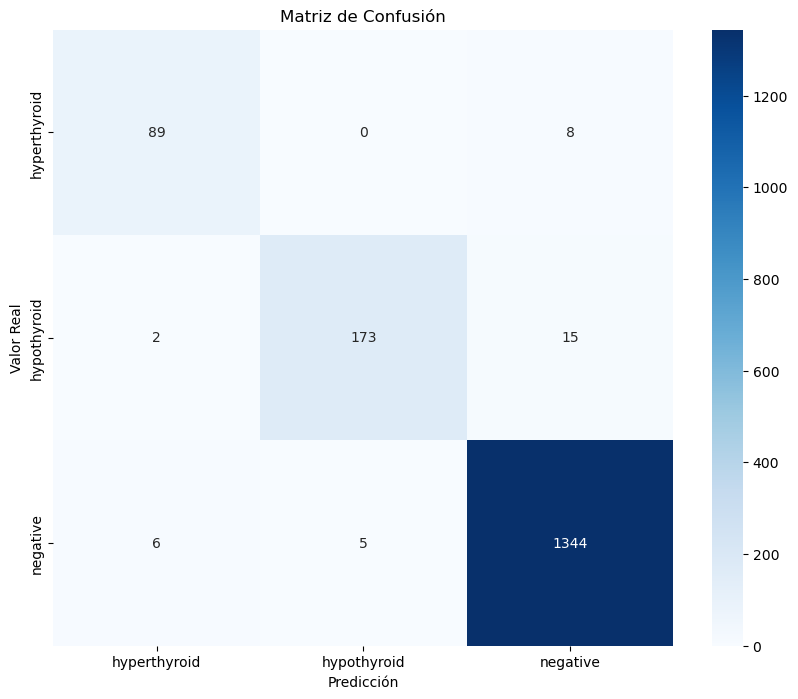

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        97
           1       0.97      0.91      0.94       190
           2       0.98      0.99      0.99      1355

    accuracy                           0.98      1642
   macro avg       0.96      0.94      0.95      1642
weighted avg       0.98      0.98      0.98      1642



## Guardado del modelo

In [24]:
import joblib
joblib.dump(pipeline_xgb, "./life_expectancy.joblib")

['./life_expectancy.joblib']